<a href="https://colab.research.google.com/github/kangnurrohman/belajar-convolutional-neural-network/blob/main/materi/Part%203%20-%20CNN%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 2.zip", 'r')
zip_ref.extractall("/content/data")
zip_ref.close()

In [ ]:
pip install jcopdl luwiji

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset & Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
bs = 128
crop_size = 64

# train augmentation / data pipeline
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# test augmentation / data pipeline
test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size), 
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/content/data/train', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder('/content/data/test', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [8]:
feature, target = next(iter(train_loader))
feature.shape

torch.Size([128, 3, 64, 64])

In [9]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

## Arsitektur & Config

In [10]:
# Jika manual tanpa block

# nn.Conv2d(3, 8, 3, 1, 1),
# nn.ReLU(),
# nn.MaxPool2d(2, 2)

In [13]:
from jcopdl.layers import conv_block, linear_block

In [17]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        conv_block(3, 8),
        conv_block(8, 16),
        conv_block(16, 32),
        conv_block(32, 64),
        nn.Flatten()
    )
    self.fc = nn.Sequential(
        linear_block(1024, 256, dropout=0.1),
        linear_block(256, 2, activation="lsoftmax")
    )
  
  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [18]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

## Training Preparation -> MCOC

In [19]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='/content/data/model')

## Training

In [20]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost / len(dataset)
  acc = correct / len(dataset)
  return cost, acc

Test: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]



Epoch     1
Train_cost  = 0.6963 | Test_cost  = 0.6896 | Train_score = 0.5030 | Test_score = 0.5000 |


Test: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]



Epoch     2
Train_cost  = 0.6846 | Test_cost  = 0.6682 | Train_score = 0.6400 | Test_score = 0.6075 |


Test: 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]



Epoch     3
Train_cost  = 0.6411 | Test_cost  = 0.5672 | Train_score = 0.6720 | Test_score = 0.7550 |


Test: 100%|██████████| 4/4 [00:00<00:00,  7.33it/s]



Epoch     4
Train_cost  = 0.5138 | Test_cost  = 0.4248 | Train_score = 0.7610 | Test_score = 0.8200 |


Test: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]



Epoch     5
Train_cost  = 0.4525 | Test_cost  = 0.4759 | Train_score = 0.7850 | Test_score = 0.7900 |
==> EarlyStop patience =  1 | Best test_score: 0.8200


Test: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]



Epoch     6
Train_cost  = 0.4532 | Test_cost  = 0.3893 | Train_score = 0.8010 | Test_score = 0.8300 |


Test: 100%|██████████| 4/4 [00:00<00:00,  7.33it/s]



Epoch     7
Train_cost  = 0.4116 | Test_cost  = 0.3860 | Train_score = 0.8050 | Test_score = 0.8425 |


Test: 100%|██████████| 4/4 [00:00<00:00,  7.14it/s]



Epoch     8
Train_cost  = 0.3995 | Test_cost  = 0.3808 | Train_score = 0.8320 | Test_score = 0.8425 |
==> EarlyStop patience =  1 | Best test_score: 0.8425


Test: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]



Epoch     9
Train_cost  = 0.3921 | Test_cost  = 0.3491 | Train_score = 0.8270 | Test_score = 0.8550 |


Test: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]



Epoch    10
Train_cost  = 0.3858 | Test_cost  = 0.3891 | Train_score = 0.8300 | Test_score = 0.8275 |
==> EarlyStop patience =  1 | Best test_score: 0.8550


Test: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]



Epoch    11
Train_cost  = 0.4080 | Test_cost  = 0.4138 | Train_score = 0.8130 | Test_score = 0.8075 |
==> EarlyStop patience =  2 | Best test_score: 0.8550


Test: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s]



Epoch    12
Train_cost  = 0.3846 | Test_cost  = 0.3918 | Train_score = 0.8390 | Test_score = 0.8175 |
==> EarlyStop patience =  3 | Best test_score: 0.8550


Test: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]



Epoch    13
Train_cost  = 0.4028 | Test_cost  = 0.3626 | Train_score = 0.8200 | Test_score = 0.8550 |
==> EarlyStop patience =  4 | Best test_score: 0.8550


Test: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]



Epoch    14
Train_cost  = 0.3736 | Test_cost  = 0.3795 | Train_score = 0.8350 | Test_score = 0.8275 |
==> EarlyStop patience =  5 | Best test_score: 0.8550
==> Execute Early Stopping at epoch: 14 | Best test_score: 0.8550
==> Best model is saved at /content/data/model


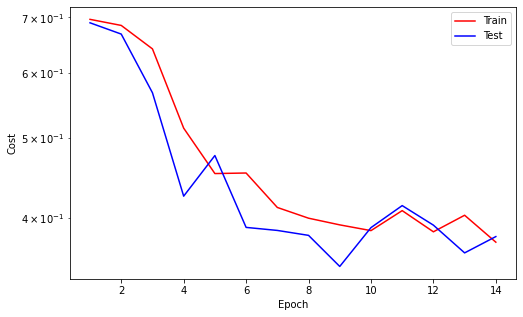

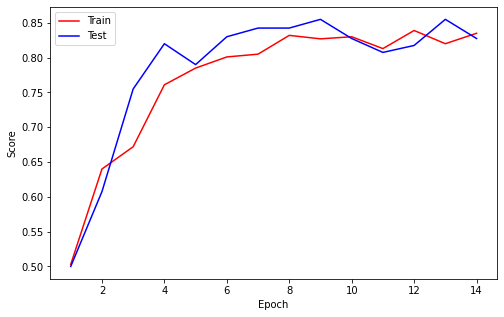

In [21]:
while True:
  train_cost, train_score = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Predict

In [22]:
feature, target = next(iter(test_loader))
feature, target = feature.to(device), target.to(device)

In [23]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'invasive',
 'invasive',
 'invasive',
 'invasive',
 'noninvasive',
 'noninvasive',
 'noninvasive',
 'no

In [25]:
import matplotlib.pyplot as plt

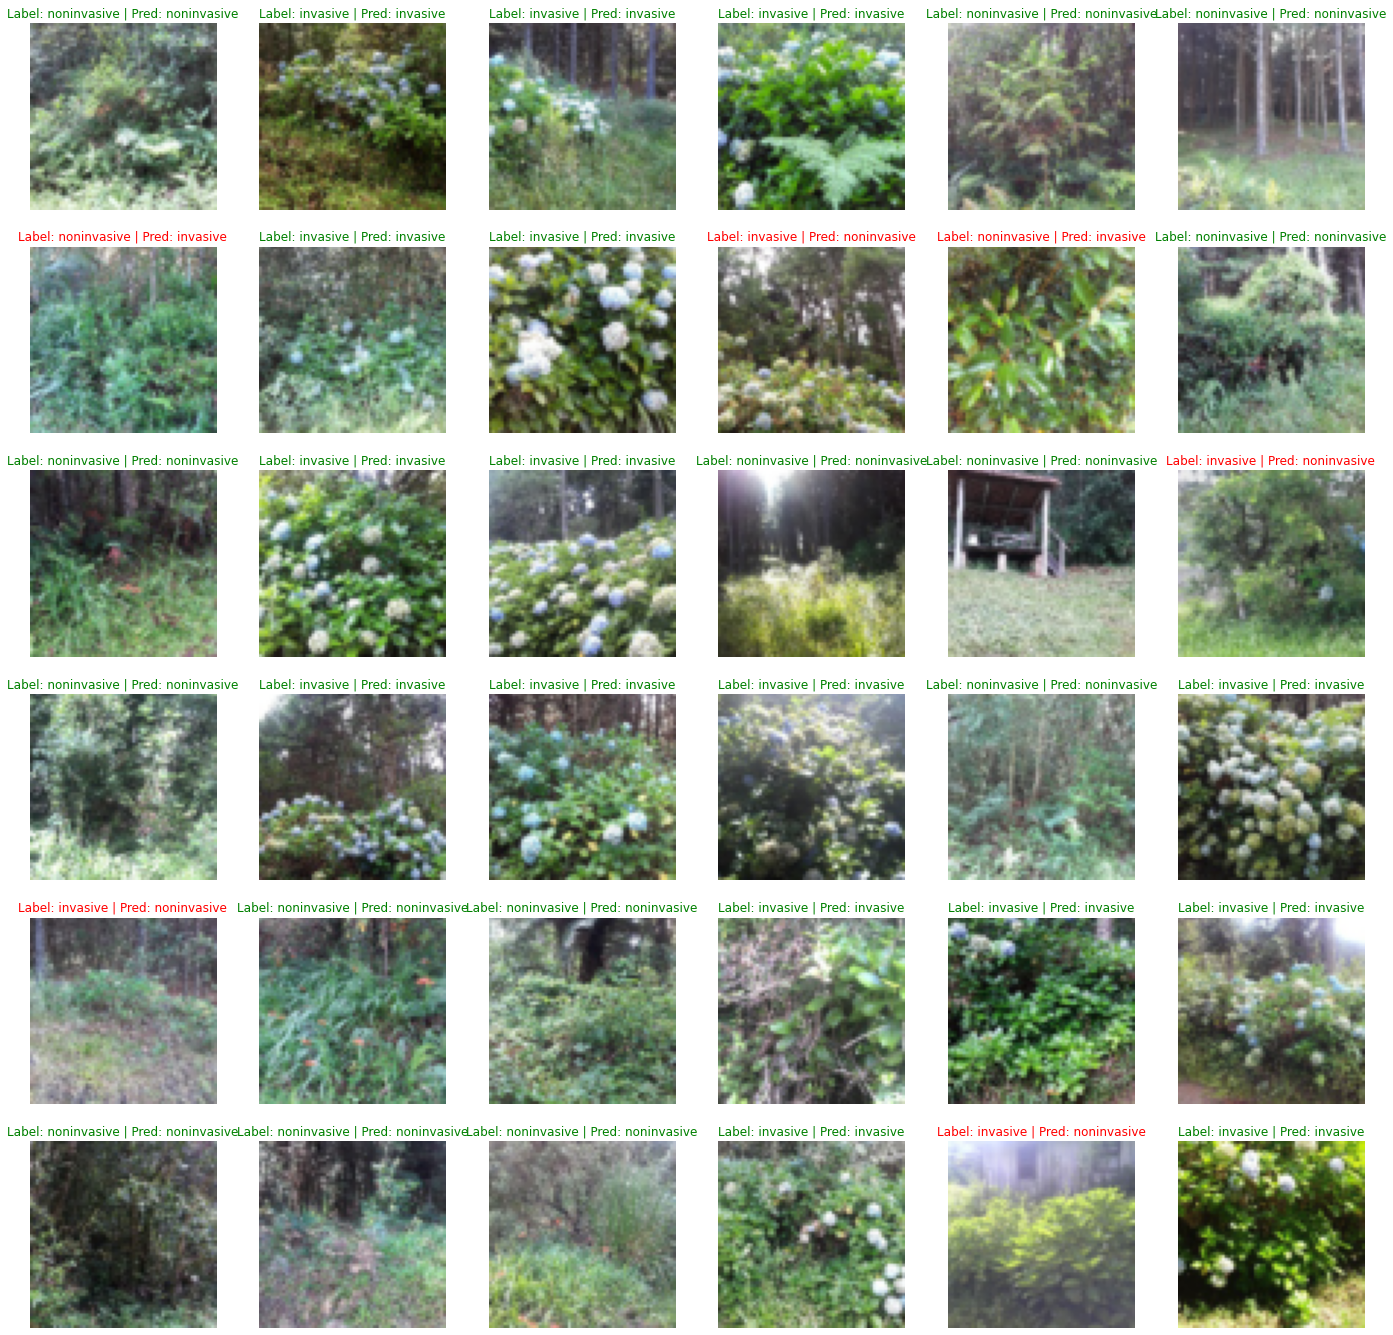

In [27]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1, 2, 0).cpu())
  font = {"color" : 'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
  ax.axis('off');